### Shallow Focusing으로 인물사진모드 만들기

```
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images
```



![img](e14im1.png)

1. 배경이 있는 셀카를 촬영
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
3. 블러링(blurring) 기술로 배경을 흐리게 
4. 피사체를 배경의 원래 위치에 합성


```
$ pip install opencv-python
```

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)


(2880, 2160, 3)


## Segmentation 이란?

 - 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법.
 
 1. Semantic segmenation  : 물리적 의미 단위로 인식하는 것.
 
 2. Instanace segmentation : 사람 개개인 별로 다른 라벨을 갖도록 Segmenation
 
 
- 물체의 경계를 나누는 것이 가장 쉬운 방법이다.
#### 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있는데요. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

참고 : https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html

## Segmentation 구현 

- Deeplab(v 3+) 사용하기.
참고 : https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

 - Deeplab Demo : https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수. 
1. input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리. 
2. 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize
3. OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
4. 전처리된 이미지는 run() 함수에서 입력값으로 사용

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


1. 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 

2. DeepLabModel 을 초기화. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전
출처 : https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2880, 2160, 3) (513, 384, 3) 15


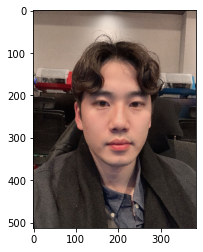

In [13]:
img_resized_origin = img_resized
seg_map_origin = seg_map
img_resized_origin= cv2.cvtColor(img_resized_origin, cv2.COLOR_RGB2BGR)
plt.imshow(img_resized_origin)

(513, 384)

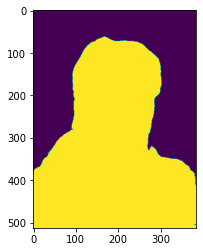

In [19]:
plt.imshow(seg_map)
seg_map.shape

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15]])

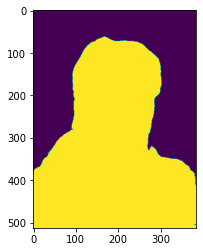

In [33]:
seg_map_origin = np.where(seg_map == 15, 15, 0)
plt.imshow(seg_map_origin)
seg_map_origin

DeepLab은 PASCAL VOC의 라벨로 학습됨
#### 제공하는 라벨 종류

In [34]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

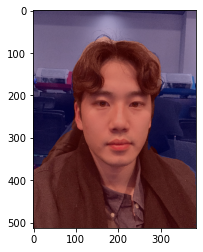

In [39]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

1. 사람을 뜻하는 15 외 예측은 0으로 만듬.
2. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15,
3. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화.
4. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력

## 이미지를 원래 크기로 복원

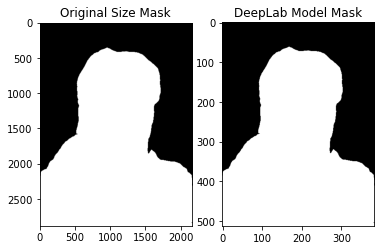

In [40]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경만 추출하기
bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기 : https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask

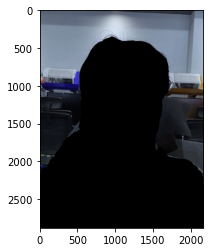

In [41]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

### Blur 처리하기

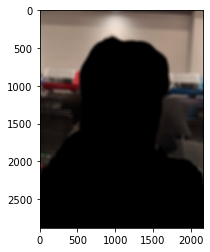

In [44]:
img_bg_blur = cv2.blur(img_bg, (50,50))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

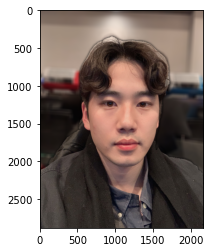

In [51]:
img_concat = np.where(img_mask_color==255, img_orig,img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()